In [43]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.3,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [44]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [45]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (35000, 32, 32, 3) (35000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (15000, 32, 32, 3) (15000,)


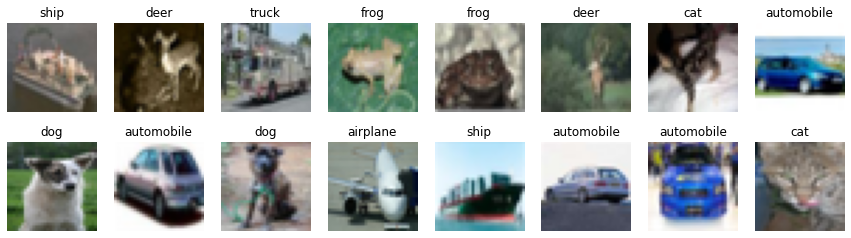

In [46]:
# show some random images from train, and their labels
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [47]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [48]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [100]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    
    # dropouts were added throughout

    # base is a double VGG block
    
    # added image preprocessing in the form of image flipping

    # i also tried image upscaling using bicubic interpolation: a bit of research showed bicubic to be effective at edge preservation and it was faster than other methods
    # however it did not influence results enough to warrant the larger conv layer (and still much longer runtime)

    # batch normalization was added to increase training speed


    model = keras.Sequential([
        
        keras.layers.RandomFlip(mode="horizontal",input_shape=(32, 32, 3)),
        
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.2),

        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Dropout(0.3),

        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(10, activation=tf.nn.softmax)
        
    ])

    # Ensure normalized probabilities over the 10 classes
    model.add(Activation("softmax")) 

    return model

Epoch 1/50
44/44 [==============================] - 8s 145ms/step - loss: 2.2092 - accuracy: 0.2401 - val_loss: 2.3118 - val_accuracy: 0.0941
Epoch 2/50
44/44 [==============================] - 5s 109ms/step - loss: 2.1106 - accuracy: 0.3578 - val_loss: 2.3166 - val_accuracy: 0.1013
Epoch 3/50
44/44 [==============================] - 5s 109ms/step - loss: 2.0694 - accuracy: 0.4013 - val_loss: 2.3165 - val_accuracy: 0.1127
Epoch 4/50
44/44 [==============================] - 5s 115ms/step - loss: 2.0364 - accuracy: 0.4379 - val_loss: 2.3181 - val_accuracy: 0.1015
Epoch 5/50
44/44 [==============================] - 5s 109ms/step - loss: 2.0135 - accuracy: 0.4620 - val_loss: 2.3214 - val_accuracy: 0.1011
Epoch 6/50
44/44 [==============================] - 5s 111ms/step - loss: 1.9910 - accuracy: 0.4835 - val_loss: 2.3186 - val_accuracy: 0.1026
Epoch 7/50
44/44 [==============================] - 5s 119ms/step - loss: 1.9751 - accuracy: 0.5023 - val_loss: 2.3019 - val_accuracy: 0.1157
Epoch 

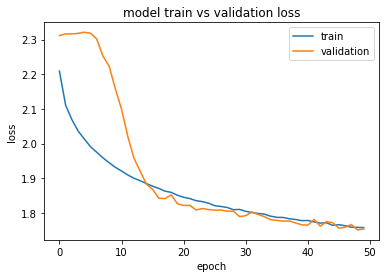

In [101]:
from matplotlib import pyplot

INIT_LR = 5e-4  # initial learning rate
BATCH_SIZE = 800
EPOCHS = 50


K.clear_session()
model = make_model()

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
history = model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")
# plot performance, only plotted loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [108]:
# the model suffers overfitting, could be improved by lowering the dense layer's count
# at the same time, another VGG block might have given the model the ability to distinguish more features and fit itself better

# NOTE - I wanted to use a datagenerator (and multiple other strategies) but sadly I tested them when I still had a bad base model. The main thing I learnt from this excercise
# was to start by exploring base model options before trying the fancy stuff.

In [103]:
# a summary, used it for debugging and making sure the model look pretty
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0

In [104]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

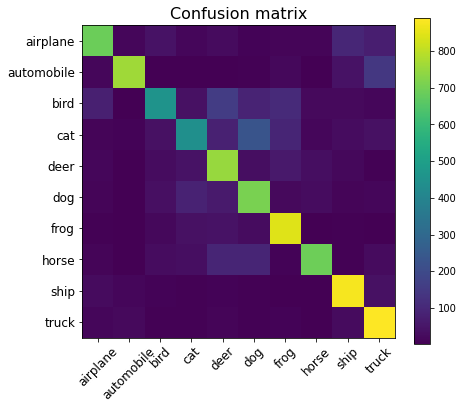

Test accuracy: 0.7118


In [105]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

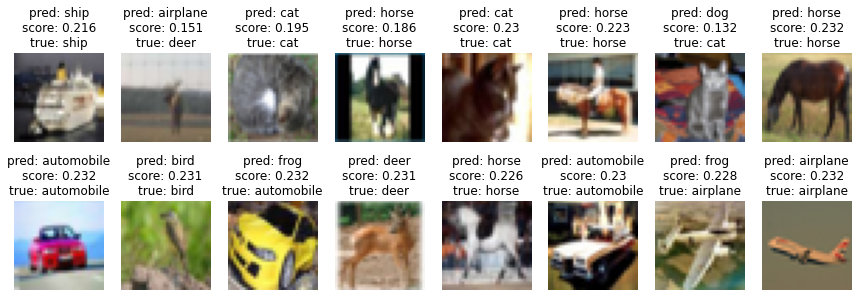

In [106]:
# inspect predictions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

#could be worse :) I definitely couldn't label some of these, and that airplane has some frog-lke features i guess...